In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


##### *Basic library imports*

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


In [4]:
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")


##### *Let's take a look at our training data!*

In [5]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


##### *Our target!*

In [6]:
train.SalePrice

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [7]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
train.select_dtypes(include = ['int', 'float']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [9]:
train.select_dtypes(include = ['object']).columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

##### *Visualising some of the features, their influence on target variable*

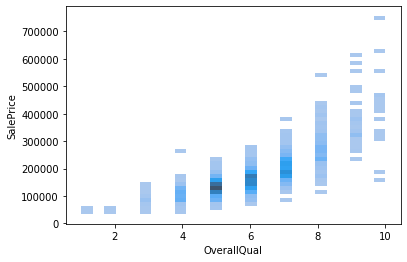

In [10]:
ax = sns.histplot( x='OverallQual', y="SalePrice", data=train)


<AxesSubplot:xlabel='MoSold', ylabel='count'>

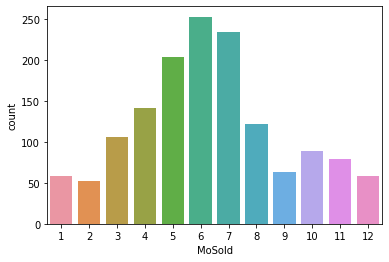

In [11]:
sns.countplot( x='MoSold', data=train)

<AxesSubplot:xlabel='MSZoning', ylabel='count'>

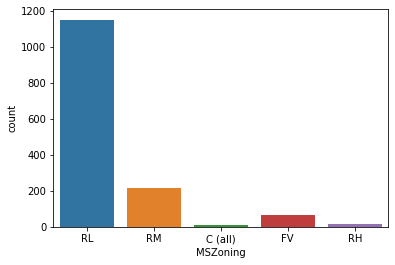

In [12]:
sns.countplot( x='MSZoning', data=train)

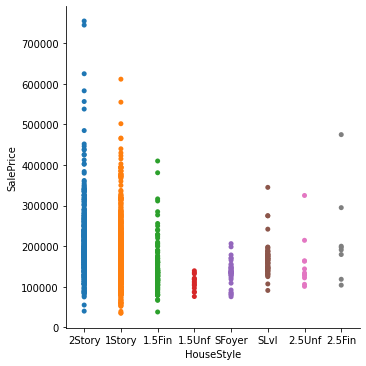

In [13]:
sns.catplot(x="HouseStyle", y="SalePrice",jitter=False, data=train)

##### *Correlation mapping*

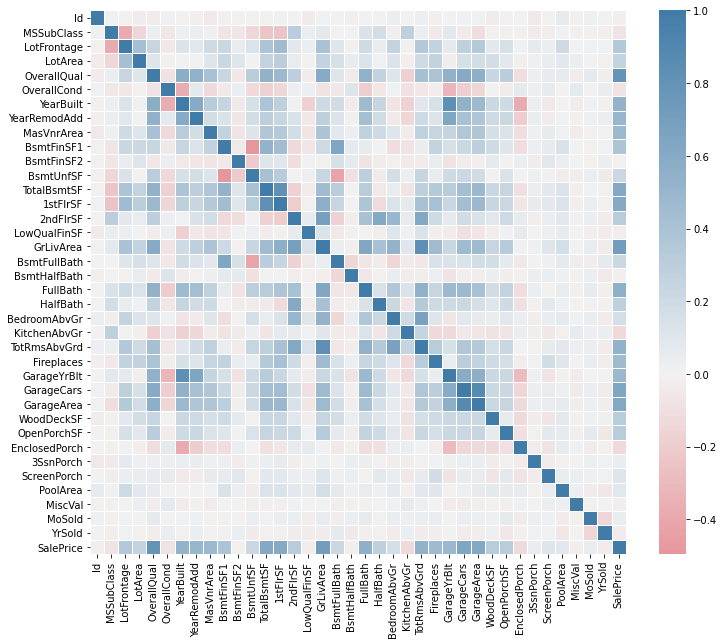

In [14]:
corr = train.corr()
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap = True)
ax = sns.heatmap(corr, center=0, cmap=cmap, linewidths=1, fmt=".2f")


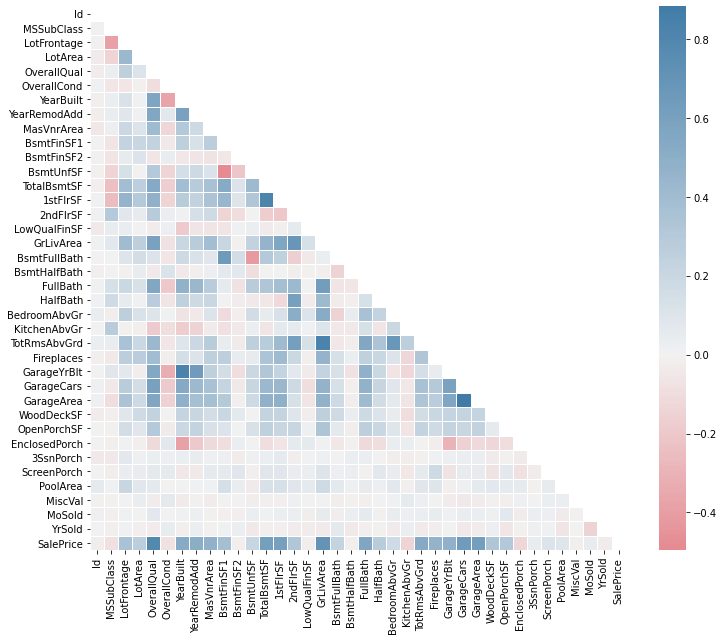

In [15]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr, mask=mask, center=0, cmap=cmap, linewidths=1, fmt=".2f")

##### *Correlation value of all features with respect to target variable*

In [16]:
corr_with_saleprice = train.corrwith(train["SalePrice"]).sort_values(ascending=False).to_frame()
corr_with_saleprice

,0
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


##### *Dropping features with less correlation value*

In [17]:
numcols_to_drop = corr_with_saleprice[corr_with_saleprice[0] < 0.1].index
numcols_to_drop

Index(['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
       'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass',
       'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')

In [18]:
train = train.drop(numcols_to_drop, axis=1)
train

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,0,61,0,NaN,NaN,NaN,WD,Normal,208500
1,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,...,Y,298,0,0,NaN,NaN,NaN,WD,Normal,181500
2,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,Y,0,42,0,NaN,NaN,NaN,WD,Normal,223500
3,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,Y,0,35,0,NaN,NaN,NaN,WD,Abnorml,140000
4,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,...,Y,192,84,0,NaN,NaN,NaN,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,0,40,0,NaN,NaN,NaN,WD,Normal,175000
1456,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,349,0,0,NaN,MnPrv,NaN,WD,Normal,210000
1457,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,0,60,0,NaN,GdPrv,Shed,WD,Normal,266500
1458,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,Y,366,0,0,NaN,NaN,NaN,WD,Normal,142125


In [19]:
pd.options.display.max_rows = 100
train.columns
train.shape
train.isnull().sum()


MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
BsmtFullBath        0
FullBath            0
HalfBath            0
BedroomAbv

In [20]:
null_columns = train.columns[train.isnull().any()]
null_columns

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

##### *Replacing null numerical columns with mean value*

In [21]:

lotfrontage_mean = train["LotFrontage"].mean().round(1)
train["LotFrontage"].fillna(lotfrontage_mean, inplace=True)


In [22]:
null_columns_categorical = null_columns.drop(labels='LotFrontage')
null_columns_categorical

Index(['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

##### *Replacing null categorical columns with the most frequent category*

In [23]:
for c in null_columns_categorical:
    train[c].fillna(train[c].value_counts().idxmax(), inplace=True)
train.isnull().sum()    

MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt 

In [24]:

train_features = train.drop(["SalePrice"], axis=1)
train_features

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,65.0,8450,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,61,0,Gd,MnPrv,Shed,WD,Normal
1,RL,80.0,9600,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,...,TA,Y,298,0,0,Gd,MnPrv,Shed,WD,Normal
2,RL,68.0,11250,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,42,0,Gd,MnPrv,Shed,WD,Normal
3,RL,60.0,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,...,TA,Y,0,35,0,Gd,MnPrv,Shed,WD,Abnorml
4,RL,84.0,14260,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,...,TA,Y,192,84,0,Gd,MnPrv,Shed,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,62.0,7917,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,40,0,Gd,MnPrv,Shed,WD,Normal
1456,RL,85.0,13175,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,349,0,0,Gd,MnPrv,Shed,WD,Normal
1457,RL,66.0,9042,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,60,0,Gd,GdPrv,Shed,WD,Normal
1458,RL,68.0,9717,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,366,0,0,Gd,MnPrv,Shed,WD,Normal


In [25]:
train_target = train[["SalePrice"]]
train_target

,SalePrice
0,208500
1,181500
2,223500
3,140000
4,250000
...,...
1455,175000
1456,210000
1457,266500
1458,142125


##### *Encoding & Standardising*

In [26]:
ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")
train_features_encoded = ohe.fit_transform(train_features)
train_features_encoded

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [27]:
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features_encoded)


In [28]:
X = train_features_scaled
y = train_target

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=21)


##### *Linear Regression*

In [30]:
#lr = LinearRegression()
#score_lr = cross_val_score(lr, X_train, y_train, cv=10)
#score_lr.mean()


##### *Ridge Regression*

In [31]:
#rg = Ridge(alpha=0.1)
#score_rg= cross_val_score(rg, X_train, y_train, cv=10)
#score_rg.mean()


##### *Lasso Regression*

In [32]:
#lasso = Lasso(alpha=0.5, max_iter = 10000, normalize=False)
#score_lasso = cross_val_score(lasso, X_train, y_train, cv=10)
#score_lasso.mean()

##### *Decision Tree regressor*

In [33]:

#dt = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 0.1, random_state = 3)#
#score_dt = cross_val_score(dt, X_train, y_train, cv=10)
#score_dt.mean()

# Gridsearch CV for Lasso Regression

In [34]:
param_dist = { "alpha": [3.0, 2.0, 1.0, 0.8, 0.5]}
ls = Lasso(max_iter = 10000, normalize=False)
grid_search = GridSearchCV(estimator=ls, param_grid=param_dist, verbose=1, cv=10)
grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': [3.0, 2.0, 1.0, 0.8, 0.5]}, verbose=1)

In [35]:
y_pred = grid_search.predict(X_val)
y_pred

array([171611.73467616, 181801.00056796, 315183.83718622, 198278.08859301,
        97049.50490376, 320702.57627979, 180771.45274907, 404970.67205295,
       371866.33800562, 141068.6448967 , 153939.60460412, 216214.46153649,
       170720.92609415, 138401.42313234, 169685.56980981, 145148.8857015 ,
       240852.93801527, 103313.38067652, 220344.18073   ,  90984.98918648,
       170969.56212045, 139265.40445061, 227849.50472682, 161835.21205457,
       223474.17469632, 493004.00528137, 148708.99709134, 153678.84108048,
       113857.87668082, 169460.03733302, 216350.05505766, 128187.19372528,
       152127.54357375, 158130.5420277 , 193823.49452834,  90650.2434848 ,
       289612.43260163, 148588.56225137, 187225.05782929, 193352.28157268,
       177698.68433586, 191984.58545256, 112114.15413511, 268576.34329746,
        99254.48833504, 156277.43119539, 162073.83600226, 322361.6014447 ,
       220853.05980236, 241404.86537748, 136166.73692962, 178135.87538192,
       102171.59490053, 2

In [36]:
grid_search.best_score_

0.8240681810416571

In [37]:
grid_search.best_estimator_

Lasso(alpha=3.0, max_iter=10000)

In [38]:
grid_search.best_params_

{'alpha': 3.0}

##### *Parameter tuning results*

In [39]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,30.643016,3.705430,0.006692,0.002932,3.0,{'alpha': 3.0},0.717509,0.808547,0.861111,0.771139,0.873698,0.823112,0.889797,0.753056,0.872739,0.869975,0.824068,0.056633,1
1,42.549952,2.981070,0.005286,0.002058,2.0,{'alpha': 2.0},0.714682,0.807927,0.859817,0.770172,0.872234,0.820656,0.888899,0.750788,0.867926,0.868259,0.822136,0.056703,2
2,38.339497,4.342422,0.007323,0.004847,1.0,{'alpha': 1.0},0.704549,0.786628,0.841403,0.734453,0.875888,0.823820,0.850751,0.712126,0.838541,0.854304,0.802246,0.060256,3
3,41.234686,1.673592,0.004685,0.000284,0.8,{'alpha': 0.8},0.704446,0.783351,0.824375,0.726803,0.872263,0.824859,0.828820,0.692483,0.830929,0.829352,0.791768,0.058933,4
4,48.947937,2.291725,0.006393,0.002113,0.5,{'alpha': 0.5},0.669501,0.756229,0.784771,0.663595,0.835485,0.821776,0.740988,0.640943,0.781776,0.747047,0.744211,0.063491,5


##### *Visualising alpha value for more accuracy*

[Text(0.5, 0, 'alpha'), Text(0, 0.5, 'Mean Test Score')]

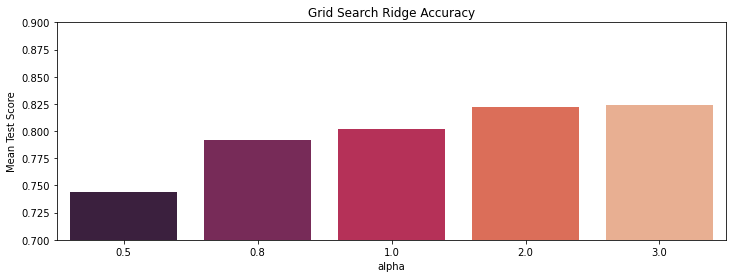

In [40]:
fig,ax = plt.subplots(figsize=(12,4))
sns.barplot(data=grid_search.cv_results_, x='param_alpha', y='mean_test_score', ax=ax, palette='rocket')
ax.set(ylim=(0.7, 0.9))
ax.set(title="Grid Search Ridge Accuracy")
ax.set(xlabel="alpha", ylabel="Mean Test Score")

##### *Best Estimator*

In [41]:
model = grid_search.best_estimator_

In [42]:
model.fit(X_train, y_train)
model.score(X_val, y_val)


0.8227027117135364

##### *Test Data*

In [43]:
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

In [44]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [45]:
test.shape

(1459, 80)

##### *Test Data cleaning*

In [46]:
numcols_to_drop

Index(['PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
       'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass',
       'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')

In [47]:
test = test.drop(numcols_to_drop, axis=1)
test

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,140,0,120,NaN,MnPrv,NaN,WD,Normal
1,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,...,TA,Y,393,36,0,NaN,NaN,Gar2,WD,Normal
2,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,212,34,0,NaN,MnPrv,NaN,WD,Normal
3,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,...,TA,Y,360,36,0,NaN,NaN,NaN,WD,Normal
4,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,...,TA,Y,0,82,144,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,NaN,Y,0,0,0,NaN,NaN,NaN,WD,Normal
1455,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,0,24,0,NaN,NaN,NaN,WD,Abnorml
1456,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,TA,Y,474,0,0,NaN,NaN,NaN,WD,Abnorml
1457,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,...,NaN,Y,80,32,0,NaN,MnPrv,Shed,WD,Normal


In [48]:
test.shape

(1459, 67)

In [49]:
test.isnull().sum()

MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
GrLivArea           0
BsmtFullBath        2
FullBath            0
HalfBath            0
BedroomAbv

In [50]:
null_columns_test = test.columns[test.isnull().any()]
null_columns_test

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [51]:
#null_columns_numerical_test
lotfrontage_mean_test = test["LotFrontage"].mean().round(1)
test["LotFrontage"].fillna(lotfrontage_mean_test, inplace=True)

In [52]:
null_columns_categorical_test = null_columns_test.drop(labels='LotFrontage')
null_columns_categorical_test

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [53]:
for c in null_columns_categorical_test:
    test[c].fillna(test[c].value_counts().idxmax(), inplace=True)
test.isnull().sum()   

MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
BsmtFullBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt 

In [54]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 67 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1459 non-null   object 
 1   LotFrontage    1459 non-null   float64
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   object 
 4   Alley          1459 non-null   object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1459 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  YearBuilt      1459 non-null   int64  
 17  YearRemodAdd   1459 non-null   int64  
 18  RoofStyl

##### *Test features Encoding & Standardising*

In [55]:

test_encoded = ohe.transform(test)
test_encoded

array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [56]:
X_test = scaler.transform(test_encoded)

In [57]:

X_test.shape

(1459, 7244)

##### *Fitting test data on the best estimator*

In [58]:
model.fit(X, y)
target = model.predict(X_test)
target

array([127553.28579939, 151822.12506174, 198120.82555162, ...,
       407549.09537111, 138880.49103846, 241964.86205752])

##### *Output Dataframe*

In [59]:
df = pd.DataFrame(data= np.array(target), columns=["SalePrice"])
df

,SalePrice
0,127553.285799
1,151822.125062
2,198120.825552
3,201975.645391
4,244387.985475
...,...
1454,79902.210858
1455,80436.189210
1456,407549.095371
1457,138880.491038


In [60]:
df[['Id']] = sample_submission.Id
output = df[["Id", "SalePrice"]]
output

,Id,SalePrice
0,1461,127553.285799
1,1462,151822.125062
2,1463,198120.825552
3,1464,201975.645391
4,1465,244387.985475
...,...,...
1454,2915,79902.210858
1455,2916,80436.189210
1456,2917,407549.095371
1457,2918,138880.491038


In [61]:
 
output.to_csv("House_price_submission", index=False)